## Global variables

In [1]:
redo_training = False

path_to_text_classifiers = 'pickle_files/text_classifiers_2020-01-09_12-20.pickle'

# Building dataset

In [2]:
#Dataset link : http://ai.stanford.edu/~amaas/data/sentiment/
import glob, os, pickle, datetime, wordcloud, nltk, string,time
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from joblib import Parallel,delayed, parallel_backend

In [3]:
train_positive_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/train/pos/*.txt')
train_negative_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/train/neg/*.txt')

test_positive_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/test/pos/*.txt')
test_negative_reviews_paths = glob.glob(r'datasets/movies_reviews_dataset/test/neg/*.txt')

In [4]:
train_data = []
train_target = []

positive_reviews = []
negative_reviews = []

for path in train_positive_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    train_data.append(text)
    train_target.append(1)
    positive_reviews.append(text)
    
for path in train_negative_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    train_data.append(text)
    train_target.append(0)
    negative_reviews.append(text)

In [5]:
test_data = []
test_target = []

for path in test_positive_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    test_data.append(text)
    test_target.append(1)
    positive_reviews.append(text)
    
for path in test_negative_reviews_paths:
    file = open(path,'r',encoding='utf8')
    text = file.read()
    test_data.append(text)
    test_target.append(0)
    negative_reviews.append(text)

In [6]:
print('training size:',len(train_data),'\ntest size:',len(test_data))

training size: 25000 
test size: 25000


# Adjectives representing positive and negative reviews

In [17]:
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ppike\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ppike\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
def pre_process(corpus):
    
    lemmatizer = WordNetLemmatizer()
    # convert input corpus to lower case.
    corpus = corpus.lower()
    # collecting a list of stop words from nltk and punctuation form
    # string class and create single array.
    stopset = stopwords.words('english') + list(string.punctuation)+['br','nt']
    # remove stop words and punctuations from string.
    # word_tokenize is used to tokenize the input corpus in word tokens.
    
    tokens = [i for i in word_tokenize(corpus) if i not in stopset]
    
    lems = [lemmatizer.lemmatize(word=item) for item in tokens]
    
    corpus = " ".join(lems)
    # remove non-ascii characters
    #corpus = unidecode(corpus)
    return corpus

In [25]:
start_time = time.time()

with parallel_backend('threading',n_jobs=-1):
    text_pos = ' '.join(positive_reviews)
    text_pos = pre_process(text_pos)

end_time = time.time()
print('Executed in : ',end_time-start_time,'s')

Executed in :  70.6763801574707 s


In [14]:
start_time = time.time()

text_neg = ' '.join(negative_reviews)
text_neg = pre_process(text_neg)

end_time = time.time()
print('Executed in : ',end_time-start_time,'s')

Executed in :  76.49722003936768 s


In [26]:
corpus = [text_pos,text_neg]

In [27]:
tfidf_vectorizer = TfidfVectorizer()

with parallel_backend('threading',n_jobs=-1):
    feature_vectors = tfidf_vectorizer.fit_transform(corpus)
    feature_names = tfidf_vectorizer.get_feature_names()

print(feature_vectors.shape)
print(len(feature_names))

(2, 95360)
95360


In [35]:
def get_adjectives(document):
    doc = document

    tfidf_scores = []
    words = []

    print('non_zero',doc.count_nonzero())
    print('shape',doc.get_shape(),'\n')

    nz = doc.nonzero()

    for i,j in zip(nz[0],nz[1]):
        words.append(feature_names[j])
        tfidf_scores.append(doc[i,j])

    tfidf_table = pd.DataFrame()
    tfidf_table['Word'] = words
    tfidf_table['Score'] = tfidf_scores
    tfidf_table['Tag'] = nltk.pos_tag(tfidf_table['Word'])

    tags = pd.DataFrame(tfidf_table['Tag'].tolist(),index=tfidf_table.index)
    tfidf_table['Tag'] = tags[1]

    tfidf_table.sort_values(by='Score',ascending=False,inplace=True)
    adjectives = tfidf_table.where(tfidf_table['Tag'] == 'JJ')
    adjectives.dropna(inplace=True)
    
    return adjectives

non_zero 70161
shape (1, 95360) 



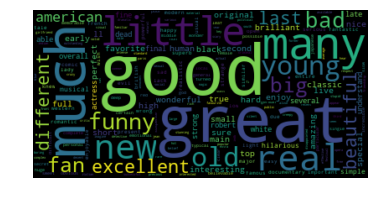

In [36]:
pos_adj = get_adjectives(feature_vectors[0])


wc = wordcloud.WordCloud()
wc = wc.generate_from_frequencies(dict(zip(pos_adj['Word'],pos_adj['Score'])))

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

non_zero 67429
shape (1, 95360) 



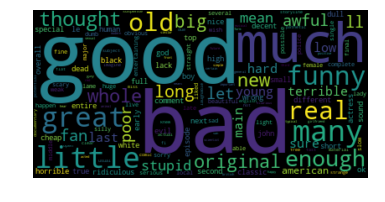

In [37]:
neg_adj = get_adjectives(feature_vectors[1])


wc = wordcloud.WordCloud()
wc = wc.generate_from_frequencies(dict(zip(neg_adj['Word'],neg_adj['Score'])))

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Classifiers

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [39]:
from sklearn.experimental import enable_hist_gradient_boosting 

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree

import sklearn.metrics as metrics


classifiers = [
    KNeighborsClassifier(n_jobs=-1),
    SVC(),
    ##GaussianProcessClassifier(n_jobs=-1),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10,n_jobs=-1),
    MLPClassifier(),
    AdaBoostClassifier(),
    ##GaussianNB(),
    ##QuadraticDiscriminantAnalysis(),
    SGDClassifier(n_jobs=-1),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=10,n_jobs=-1),
    GradientBoostingClassifier(),
    ##HistGradientBoostingClassifier()
]

In [40]:
text_classifiers = []

if redo_training == True:
    for clf in classifiers:
        text_clf = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf)])
        
        print('Starting: ',str(clf).split('(')[0])
        
        with parallel_backend('threading',n_jobs=-1):
            text_clf.fit(train_data,train_target)
            predictions = text_clf.predict(test_data)
            print(str(clf).split('(')[0],metrics.accuracy_score(predictions,train_target))
                  
        print('Ending: ',str(clf).split('(')[0])
        text_classifiers.append(text_clf)
        
    #Saving data to pickle file
    date = datetime.datetime.now()
    date = date.strftime('%Y-%m-%d_%H-%M')
    pickle.dump(text_classifiers,open('pickle_files/text_classifiers_'+date+'.pickle','wb'))
    print('text_classifiers were saved in pickle_files/text_classifiers_'+date+'.pickle')
    
else:
    text_classifiers = pickle.load(open(path_to_text_classifiers,'rb'))

Executed in 609.7812979221344 s
text_classifiers were saved in pickle_files/text_classifiers_2020-01-10_18-40.pickle


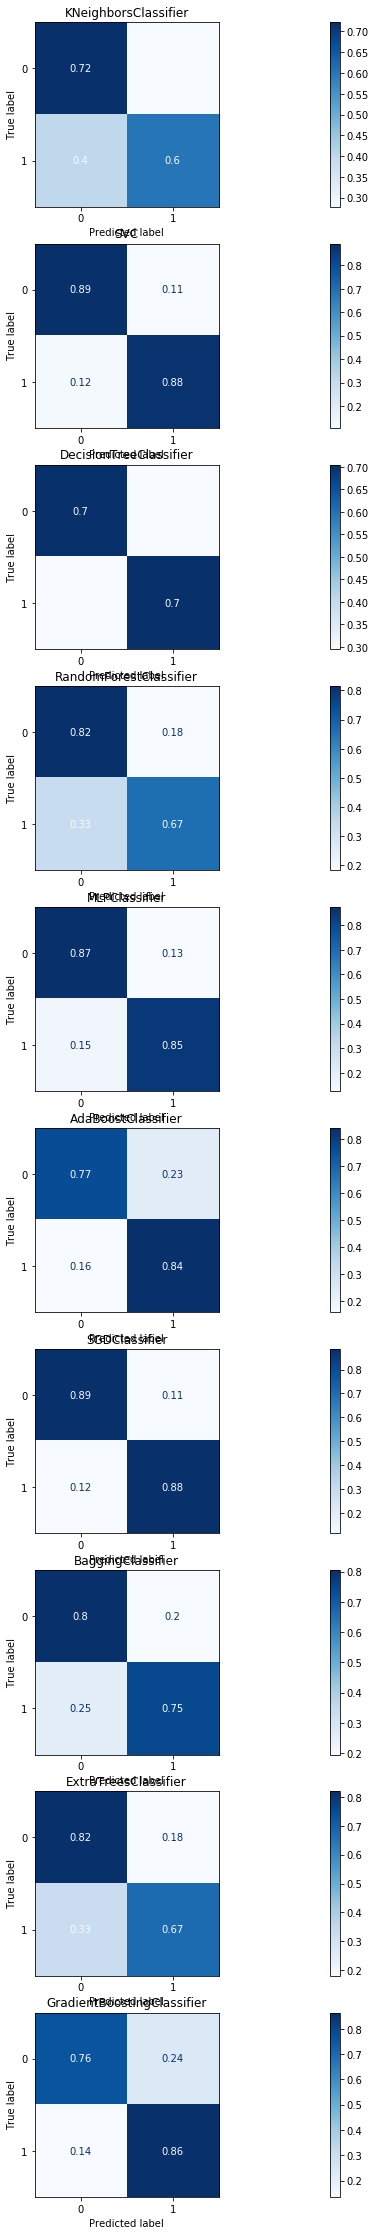

In [41]:
fig,axis = plt.subplots(len(text_classifiers),1,figsize=(40,40))
names = []
plots = []

for clf in text_classifiers:
    for s in clf.steps:
        if s[0]=='clf':
            names.append(str(s[1]).split('(')[0])

start_time = time.time()
            
for text_clf,ax,name in zip(text_classifiers,axis,names):
    ax.set_title(name)
    with parallel_backend('threading',n_jobs=-1):
        plots.append(metrics.plot_confusion_matrix(text_clf,test_data,test_target,normalize='true',cmap=plt.cm.Blues, ax=ax))

end_time = time.time()

print('Executed in',end_time-start_time,'s')

date = datetime.datetime.now()
date = date.strftime('%Y-%m-%d_%H-%M')
pickle.dump(plots,open('pickle_files/text_classifiers_confusion_matrices_'+date+'.pickle','wb'))
print('text_classifiers were saved in pickle_files/text_classifiers_'+date+'.pickle')
    
fig.savefig('text_classifiers_confusion_matrices.png')

In [81]:
%%bash
wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1bQxW6EowvkJkllsHIFnYzYugQQ3FqRRI' -O 'text_classifiers.pickle'

will be placed in the single file you specified.

--2020-01-11 19:27:17--  https://docs.google.com/uc?export=download&id=1bQxW6EowvkJkllsHIFnYzYugQQ3FqRRI
Resolving docs.google.com (docs.google.com)... 216.58.213.174, 2a00:1450:4007:805::200e
Connecting to docs.google.com (docs.google.com)|216.58.213.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: â€˜text_classifiers.pickleâ€™

     0K ...                                                    9.69M=0s

2020-01-11 19:27:17 (9.69 MB/s) - â€˜text_classifiers.pickleâ€™ saved [3271]

Loading robots.txt; please ignore errors.
--2020-01-11 19:27:17--  https://docs.google.com/robots.txt
Reusing existing connection to docs.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: â€˜text_classifiers.pickleâ€™

     0K                                                        26.0M=0s

2020-01-11 19:27:17 (26.0 MB/s) - â€˜text_classifiers.

In [83]:
test = pickle.load(open('text_classifiers.pickle','rb'))

UnpicklingError: invalid load key, '<'.